# Minimal Polynomial Recovery: Experimental Analysis

**Research Question:** What factors affect minimal polynomial recovery success using Berlekamp-Massey on Krylov sequences?    
**Types of vector sample:**
- Random vectors
- Sparse vector with k random non-zero entry (in this experiment k = 1)
- Structured vector with all entries = 1

## Helper Functions

In [1]:
from sage.matrix.berlekamp_massey import berlekamp_massey
import random
from matplotlib import pyplot as plt

In [2]:
def random_vector(n, f):
    return vector(f, [f.random_element() for _ in range(n)])

def sparse_vector(k, n, f):
    # k is number of non-zero elements
    indices = random.sample(range(n), k)
    v = [f(0)] * n
    for i in indices:
        v[i] = f.random_element()
    return vector(f, v)

def structured_vector(n, f):
    return vector(f, [1]*n) 

def generate_vectors(category, n, f):
    if category == "Random":
        return random_vector(n, f), random_vector(n, f)
    elif category == "Sparse":
        return sparse_vector(1, n, f), sparse_vector(1, n, f)
    elif category == "Structured":
        return structured_vector(n, f), structured_vector(n, f)
    else:
        raise ValueError("Unknown category")

In [3]:
def minpoly_recovery_success(A, f, trials=1000):
    n = A.nrows() # dimension of A
    success_rates = {"Random" : 0, 
                    "Sparse" : 0, 
                    "Structured" : 0 }
    min_poly = A.minpoly() # actual min poly
    for category in success_rates.keys():
        succeeded = 0
        for _ in range(trials):
            u, v = generate_vectors(category, n, f)
            kappa = [u.dot_product((A^i)*v) for i in range(2*n)] # krylov sequence
            mu = berlekamp_massey(kappa) 
            if mu == min_poly: 
                succeeded += 1
        success_rates[category] = f'{float(succeeded * 100/trials):.2f}%'
    return success_rates

In [4]:
def plot(title):
    labels = list(test_data.keys())
    random_vals = [float(test_data[label]['Random'].strip('%')) for label in labels]
    bars = plt.bar(labels, random_vals, color='steelblue')
    plt.ylabel('Random Vectors\' Success Rate (%)')
    plt.title(title)
    plt.ylim(0, 110)
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, height + 2, f'{height:.1f}%', 
                 ha='center', va='bottom', fontsize=9)
    plt.tight_layout()
    plt.show()
    
    # Print cases where sparse > 0% or structured < 100%
    anomalies = []
    for label in labels:
        sparse_rate = float(test_data[label]['Sparse'].strip('%'))
        structured_rate = float(test_data[label]['Structured'].strip('%'))
        if sparse_rate > 0 or structured_rate < 100:
            anomalies.append(f"{label}: Sparse={test_data[label]['Sparse']}, Structured={test_data[label]['Structured']}")
    
    if anomalies:
        print("Anomalies:")
        for anomaly in anomalies:
            print(f"  {anomaly}")
    else:
        print("All sparse rates = 0%, all structured rates = 100%")

## I. Experiment 1: Scalability with Matrix Dimension

**Research Question:** How does matrix size affect recovery success? Do eigenvalue multiplicities hurt performance?    
**Independent Variables:** Matrix dimensions (2×2, 16×16, 30×30), eigenvalue patterns   
**Controlled Variables:** Field GF(31), diagonal matrices, vector sampling methods   
**Dependent Variable:** Recovery success rate (%)

### A. Matrix Dimension Effect with Distinct Eigenvalues

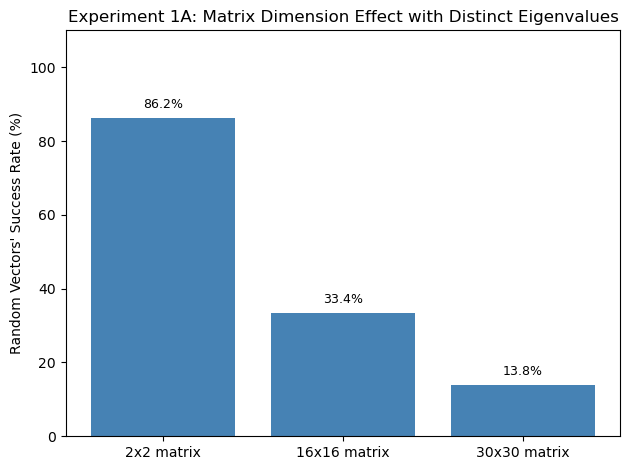

All sparse rates = 0%, all structured rates = 100%


In [5]:
# Test 1: Varying field size (n)
test_data = {}
t1_dims = [2, 16, 30]
def test10(n):
    test_name = f'{n}x{n} matrix'
    f = GF(31) # Fixed field
    A = diagonal_matrix(f, [i for i in range(1, n + 1)])
    success_rates = minpoly_recovery_success(A, f)
    test_data.update({test_name : success_rates})
    return test_data[test_name]
for n in t1_dims:
    test10(n)
plot('Experiment 1A: Matrix Dimension Effect with Distinct Eigenvalues')

### B. Matrix Dimension Effect with Uniform Eigenvalues

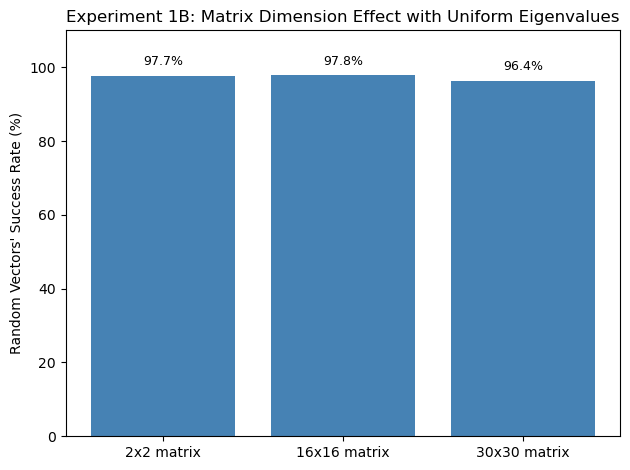

Anomalies:
  2x2 matrix: Sparse=48.30%, Structured=100.00%
  16x16 matrix: Sparse=6.90%, Structured=100.00%
  30x30 matrix: Sparse=2.90%, Structured=100.00%


In [6]:
test_data = {}
def test11(n):
    test_name = f'{n}x{n} matrix'
    f = GF(31) # Fixed field
    A = diagonal_matrix(f, [1] * (n))
    success_rates = minpoly_recovery_success(A, f)
    test_data.update({test_name : success_rates})
    return test_data[test_name]
for n in t1_dims:
    test11(n)
plot('Experiment 1B: Matrix Dimension Effect with Uniform Eigenvalues')

## Findings:
- More repeated eigenvalues → lower success rates
- Matrix size has minimal impact, showing good scalability
- Structured vectors always achieve 100% success

## II. Experiment 2: Impact of Eigenvalue Multiplicities

**Research Question:** How do eigenvalue repetition patterns affect recovery success? Do multiplicities hurt performance?  
**Independent Variables:** Eigenvalue multiplicity patterns, distribution types  
**Controlled Variables:** Field GF(31), 10×10 diagonal matrices, vector sampling methods  
**Dependent Variable:** Recovery success rate (%)

### A. Mixed multiplicity pattern $\mu_A = (x-1)^k(x-2)(x-3)\cdots$ with $k$ repeated eigenvalues

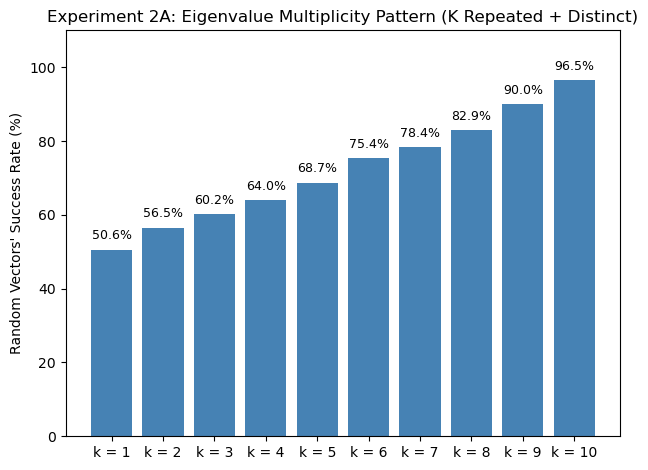

Anomalies:
  k = 10: Sparse=9.50%, Structured=100.00%


In [7]:
# Test 2
test_data = {}
def test20(n):
    test_name = f'k = {n}'
    f = GF(31) # Fixed field
    A = diagonal_matrix(f, [1] * n + [i for i in range(2, 12 - n)])
    # print(A)
    success_rates = minpoly_recovery_success(A, f)
    test_data.update({test_name : success_rates})
    return test_data[test_name]
for n in range(1, 11): 
    test20(n)
plot('Experiment 2A: Eigenvalue Multiplicity Pattern (K Repeated + Distinct)')

### B. Bipartite distribution $\mu_A = (x-1)^k(x-2)^{(10-k)}$ with two eigenvalue groups

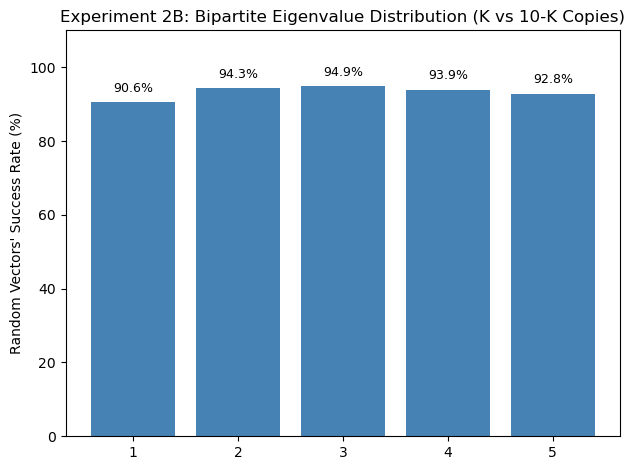

All sparse rates = 0%, all structured rates = 100%


In [8]:
test_data = {}
def test21(n):
    test_id = n
    f = GF(31) # Fixed field
    A = diagonal_matrix(f, [1] * n + [2] * (10 - n))
    # print(A)
    success_rates = minpoly_recovery_success(A, f)
    test_data.update({test_id : success_rates})
    return test_data[test_id]
for n in range(1,6):
    test21(n)
plot('Experiment 2B: Bipartite Eigenvalue Distribution (K vs 10-K Copies)')

## Findings:
- Higher eigenvalue multiplicities consistently reduce success rates
- Mixed patterns (2A) show increased success as multiplicity increases (For k = 10, in some cases even sparse vector succeeded)
- Bipartite patterns (2B) demonstrate threshold effects in recovery performance

## III. Experiment 3: Effect of Eigenvalue's numerical value
**Research Question:** Do eigenvalue numerical ranges affect recovery success?  
**Independent Variables:** Eigenvalue ranges $\{1,2,\ldots,15\}$ vs. $\{16,17,\ldots,30\}$  
**Controlled Variables:** Field GF(31), 15×15 diagonal matrices, vector sampling methods  
**Dependent Variable:** Recovery success rate (%)

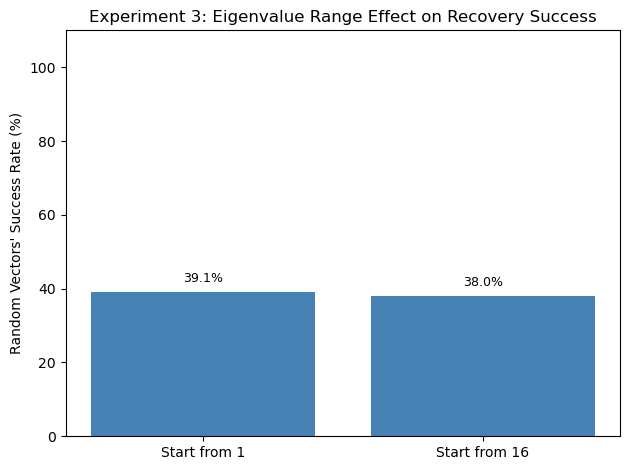

All sparse rates = 0%, all structured rates = 100%


In [15]:
# Test 3
test_data = {}
def test30(start):
    test_name = f'Start from {start}'
    f = GF(31) # Fixed field
    A = diagonal_matrix(f, [i for i in range(start, 15 + start)])
    success_rates = minpoly_recovery_success(A, f)
    test_data.update({test_name : success_rates})
    return test_data[test_name]
test30(1)
test30(16)
plot('Experiment 3: Eigenvalue Range Effect on Recovery Success')

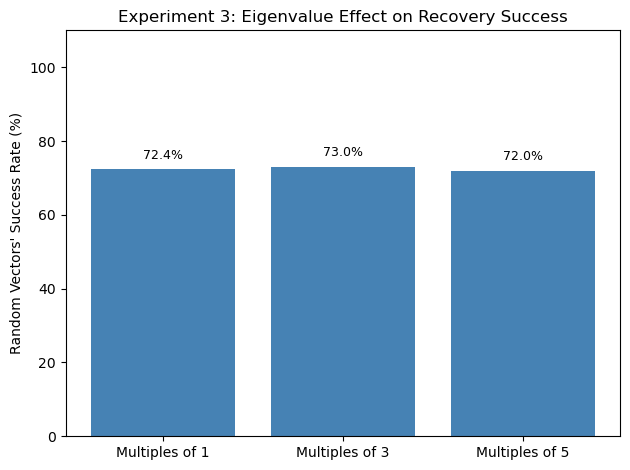

All sparse rates = 0%, all structured rates = 100%


In [16]:
test_data = {}
def test31(mult):
    test_name = f'Multiples of {mult}'
    f = GF(31) # Fixed field
    A = diagonal_matrix(f, [i * mult for i in range(1, 6)])
    success_rates = minpoly_recovery_success(A, f)
    test_data.update({test_name : success_rates})
    return test_data[test_name]
test31(1)
test31(3)
test31(5)
plot('Experiment 3: Eigenvalue Effect on Recovery Success')

## Findings:
- Similar success rates across different numerical ranges $\to$ range or values of eigenvals don't affect recovery performance

## IV. Experiment 4: Scalability with Field Size

**Research Question:** How does field size affect recovery success? Do larger fields hurt performance?  
**Independent Variables:** Field sizes $\text{GF}(2), \text{GF}(7), \text{GF}(31), \text{GF}(997)$  
**Controlled Variables:** Matrix $\text{diag}(1,2,\ldots,10)$, vector sampling methods  
**Dependent Variable:** Recovery success rate (%)

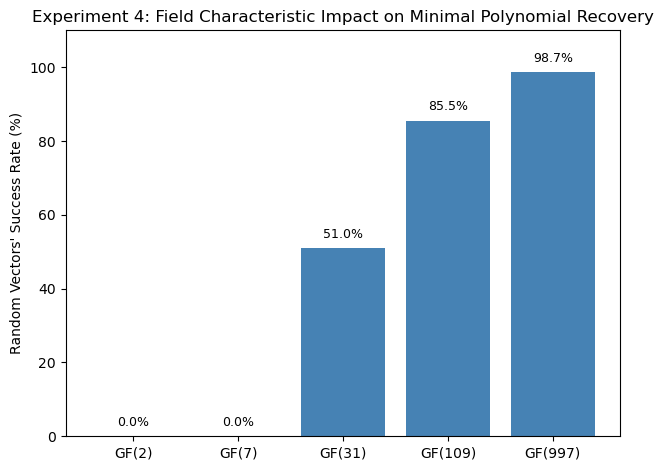

Anomalies:
  GF(2): Sparse=0.00%, Structured=0.00%
  GF(7): Sparse=0.00%, Structured=0.00%


In [10]:
field_orders = [2, 7, 31, 109, 997]
test_data = {}
def test40(order):
    test_name = f'GF({order})'
    f = GF(order)
    A = diagonal_matrix(f, [i for i in range(1, 11)])
    success_rates = minpoly_recovery_success(A, f)
    test_data.update({test_name : success_rates})
    return test_data[test_name]
for order in field_orders:
    test40(order)
plot('Experiment 4: Field Characteristic Impact on Minimal Polynomial Recovery')

### Findings:
- Larger finite fields lead to higher success rates $\to$ more field elements provide greater algebraic diversity
- For $GF(2), GF(7)$, even structured vectors failed